In [1]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pickle.load(open('clean_dataset_2022/train_set.bin', 'rb'))

test_data = pickle.load(open('clean_dataset_2022/test_set.bin', 'rb'))

## SARIMAX

In [3]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure

### Resample

In [4]:
province = ['BKK','CNX','KKC','RAY','SARA','SURAT']

In [5]:
for p in province:
    train_data[p] = train_data[p].resample('6H').mean()

    tmp_df = test_data[p].copy()
    tmp_df['PM25'] = test_data[p]['PM25'].asfreq(freq='6H')
    test_data[p] = test_data[p].resample('6H').mean()
    test_data[p]['PM25'] = tmp_df['PM25']

### Split 70% 30%

In [6]:
train_set = {} ; valid_set = {}

ratio = 0.7

for p in province:
    train_size, valid_size = int(ratio*train_data[p].shape[0]), int((1-ratio)*train_data[p].shape[0])
    train_set[p], valid_set[p] = train_data[p].iloc[:train_size], train_data[p].iloc[train_size: ]

### Tuning Parameters

In [7]:
order = (5, 1, 2)
seasonal_order = (1, 0, 1, 1461) # 365.25 * 4

exog_order = (5, 0, 4)
exog_seasonal_order = (1, 0, 1, 1461) # 365.25 * 4

exog_columns = ['Temp', 'WindSpeed', 'WindDir']

### Training 6 provinces with *minimal_SARIMAX*

In [34]:
from importlib import reload

In [38]:
from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [39]:
model = {}
model_exog = {}

for p in province:
    model[p] = MinimalSARIMAX(train_data[p][['PM25']],
                order,
                seasonal_order,
                exog=train_data[p][exog_columns])
    
    model_exog[p] = {}    
    for exog in exog_columns:
        model_exog[p][exog] = MinimalSARIMAX(train_data[p][[exog]],
                                            exog_order,
                                            exog_seasonal_order)

In [11]:
for p in province:
    model[p].fit(lr=1e-5, lr_decay=0.999 ,verbose=0)

100%|██████████| 2555/2555 [00:00<00:00, 13810.71it/s]


In [12]:
for p in province:
    for exog in exog_columns:
        if exog == 'WindDir':
            model_exog[p][exog].fit(lr=5e-7, lr_decay=0.999, verbose=0)
        else:
            model_exog[p][exog].fit(lr=1e-5, lr_decay=0.999, verbose=0)

100%|██████████| 2555/2555 [00:00<00:00, 14194.51it/s]


In [13]:
y, _ = model['BKK'].predict(train_data['BKK'][['PM25']], y_exog=train_data['BKK'][exog_columns])

In [14]:
train_data['BKK'][['Temp']].shape

(4384, 1)

In [15]:
tt = model_exog['BKK']['Temp'].predict(train_data['BKK'][['Temp']])

In [16]:
valid_set['BKK'].iloc[:,[0]]

,PM25
Time,
2019-08-07 00:00:00,12.500000
2019-08-07 06:00:00,17.166667
2019-08-07 12:00:00,18.166667
2019-08-07 18:00:00,16.666667
2019-08-08 00:00:00,13.166667
...,...
2020-06-29 18:00:00,10.166667
2020-06-30 00:00:00,10.833333
2020-06-30 06:00:00,14.500000


In [40]:
valid_set['BKK'][exog_columns]

,Temp,WindSpeed,WindDir
Time,,,
2019-08-07 00:00:00,27.566667,55.500000,275.000000
2019-08-07 06:00:00,27.183333,49.166667,279.166667
2019-08-07 12:00:00,28.650000,49.166667,284.166667
2019-08-07 18:00:00,28.250000,52.500000,287.500000
2019-08-08 00:00:00,27.366667,60.166667,285.000000
...,...,...,...
2020-06-29 18:00:00,30.233333,25.166667,260.000000
2020-06-30 00:00:00,28.566667,23.000000,255.000000
2020-06-30 06:00:00,29.183333,23.000000,253.333333


In [44]:
Result = model['BKK'].predict_step(valid_set['BKK'][['PM25']], test_data['BKK'][['PM25']], 
                                    val_X_exog=valid_set['BKK'][exog_columns], y_exog=test_data['BKK'][exog_columns], model_exog=model_exog['BKK'], learn=False)

val_pred_sav, y_pred_sav, Valid_Error, Test_Error = Result

In [45]:
print(f"Valid_Error: {(Valid_Error**2).mean()}")
print(f"Test_Error: {(Test_Error**2).mean()}")

Valid_Error: 31.32664612135717
Test_Error: 35.98213388040679


In [46]:
val_pred_sav

,Time,Predict,Actual
0,2019-08-07 00:00:00,9,12.500000
1,2019-08-07 06:00:00,23.110299,17.166667
2,2019-08-07 12:00:00,6.676353,18.166667
3,2019-08-07 18:00:00,6.044204,16.666667
4,2019-08-08 00:00:00,6.682057,13.166667
...,...,...,...
15711,2020-06-30 18:00:00,45.99961,11.500000
15712,2020-06-30 12:00:00,38.268106,11.833333
15713,2020-06-30 18:00:00,34.176263,11.500000
15714,2020-06-30 18:00:00,37.642275,11.500000


In [ ]:
val_pred_sav.to_csv('answer_dataset/val_pred_sav.csv')

In [ ]:
y_pred_sav

,Time,Predict,Actual
0,2020-07-01 00:00:00,11.521073,9.0
1,2020-07-01 06:00:00,11.521073,9.0
2,2020-07-01 12:00:00,11.521073,9.0
3,2020-07-01 18:00:00,11.521073,9.0
4,2020-07-02 00:00:00,11.521073,9.0
...,...,...,...
17497,2021-07-01 12:00:00,14.961421,14.0
17498,2021-07-01 18:00:00,14.961421,14.0
17499,2021-07-01 12:00:00,14.001249,14.0
17500,2021-07-01 18:00:00,14.001249,14.0


In [ ]:
y_pred_sav.to_csv('answer_dataset/y_pred_sav.csv')

In [ ]:
valid_set['BKK'][['PM25']]

,PM25
Time,
2019-08-07 00:00:00,12.500000
2019-08-07 06:00:00,17.166667
2019-08-07 12:00:00,18.166667
2019-08-07 18:00:00,16.666667
2019-08-08 00:00:00,13.166667
...,...
2020-06-29 18:00:00,10.166667
2020-06-30 00:00:00,10.833333
2020-06-30 06:00:00,14.500000


In [ ]:
test_data['BKK'][['PM25']]

,PM25
Time,
2020-07-01 00:00:00,9.0
2020-07-01 06:00:00,11.0
2020-07-01 12:00:00,15.0
2020-07-01 18:00:00,14.0
2020-07-02 00:00:00,18.0
...,...
2021-06-30 18:00:00,15.0
2021-07-01 00:00:00,15.0
2021-07-01 06:00:00,14.0


In [ ]:
cnx_data = pd.concat((cnx_train, cnx_valid, cnx_test), axis=0)
bkk_data = pd.concat((bkk_train, bkk_valid, bkk_test), axis=0)

NameError: name 'cnx_train' is not defined

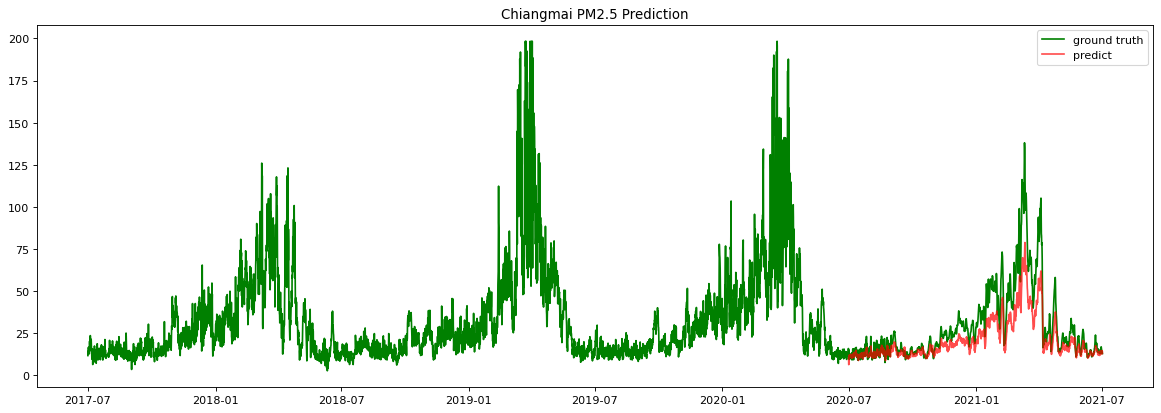

In [ ]:
model_cnx.plot(cnx_data['PM25'], cnx_y_pred['PM25'], "Chiangmai PM2.5 Prediction")

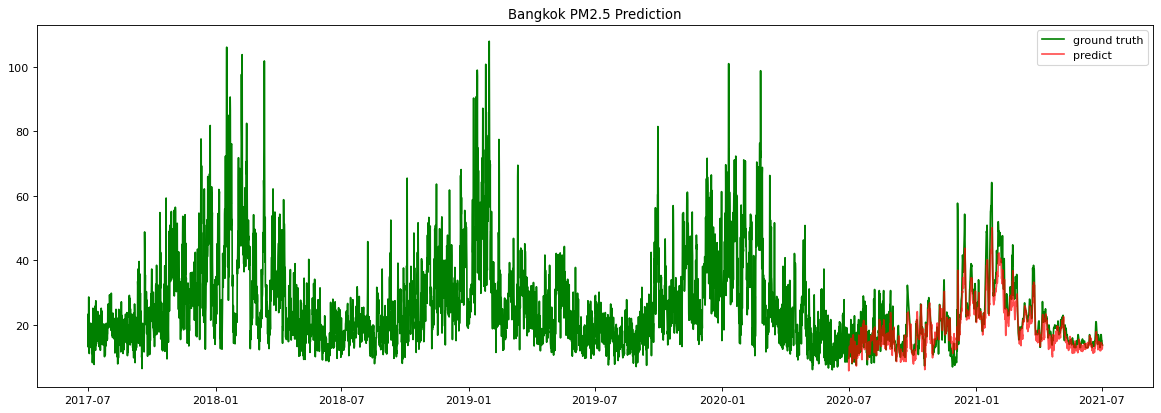

In [ ]:
model['BKK'].plot(model['BKK']['PM25'], bkk_y_pred['PM25'], "Bangkok PM2.5 Prediction")

In [ ]:
# # Open file - Write binary mode
# model_file = open('mod_cnx[0-1-1_1-1-0-365].model', 'wb')

# # Save Decision tree model
# pickle.dump(mod_cnx, model_file)

# # Close file
# model_file.close()

In [ ]:
# test_exog = pd.concat((cnx_valid[exog_columns], cnx_test[exog_columns]), axis=0)

In [ ]:
# bkk_data = pd.concat((bkk_train, cnx_valid, bkk_test), axis=0)

# Grid Search

In [16]:
import itertools

In [17]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [18]:
pdqs = [(x[0], x[1], x[2], 1461) for x in list(itertools.product(p, d, q))]
pdqs

[(0, 0, 0, 1461),
 (0, 0, 1, 1461),
 (0, 0, 2, 1461),
 (0, 1, 0, 1461),
 (0, 1, 1, 1461),
 (0, 1, 2, 1461),
 (0, 2, 0, 1461),
 (0, 2, 1, 1461),
 (0, 2, 2, 1461),
 (1, 0, 0, 1461),
 (1, 0, 1, 1461),
 (1, 0, 2, 1461),
 (1, 1, 0, 1461),
 (1, 1, 1, 1461),
 (1, 1, 2, 1461),
 (1, 2, 0, 1461),
 (1, 2, 1, 1461),
 (1, 2, 2, 1461),
 (2, 0, 0, 1461),
 (2, 0, 1, 1461),
 (2, 0, 2, 1461),
 (2, 1, 0, 1461),
 (2, 1, 1, 1461),
 (2, 1, 2, 1461),
 (2, 2, 0, 1461),
 (2, 2, 1, 1461),
 (2, 2, 2, 1461)]

In [24]:
# Define function
def sarimax_gridsearch(y_train, y_test, pdq, PDQs, x_train = None, x_test = None):
    '''
    Input: 
        y_train: training data
        y_test: test data
        pdq : ARIMA combinations 
        pdqs : seasonal ARIMA combinations 
        x_train: exogenous training data
        x_test: exogenous test data

    Return:
        Returns dataframe of parameter combinations with the least RMSE
    '''
    ans = []
    for comb in pdq:
        for combs in PDQs:
            p, d, q = comb[0], comb[1], comb[2]
            P, D, Q = combs[0], combs[1], combs[2]
            if (p+q <= 2) and (d <= 2) and (d+D <= 2) and (P+Q <= 1):  
                try:
                    model = MinimalSARIMAX(y_train, comb, combs, exog=x_train)
                    model.fit(lr=1e-5, lr_decay=0.999 ,verbose=0) 
                    y_pred, err = model.predict(y_test, y_X=x_test, verbose=0)
                    y_pred = pd.DataFrame(y_pred['PM25'])
                    rmse = model.scoring(y_pred, y_test)
                    ans.append([comb, combs, rmse])
                    # print(f'SARIMAX {comb} x {combs} : RMSE Calculated ={rmse}')
                except Exception as e: 
                    # print(e)
                    continue

    # Convert into a dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'rmse'])

    # Sort and return a combination with the lowest RMSE
    ans_df = ans_df.sort_values(by=['rmse'],ascending=True)
    
    return ans_df.iloc[0]

In [20]:
pm_train_bkk = train_data[province[0]][['PM25']]
pm_test_bkk = test_data[province[0]][['PM25']]
exo_train_bkk = train_data[province[0]][exog_columns]
exo_test_bkk = test_data[province[0]][exog_columns]

pm_train_cnx = train_data[province[1]][['PM25']]
pm_test_cnx = test_data[province[1]][['PM25']]
exo_train_cnx = train_data[province[1]][exog_columns]
exo_test_cnx = test_data[province[1]][exog_columns]

pm_train_kkc = train_data[province[2]][['PM25']]
pm_test_kkc = test_data[province[2]][['PM25']]
exo_train_kkc = train_data[province[2]][exog_columns]
exo_test_kkc = test_data[province[2]][exog_columns]

pm_train_ray = train_data[province[3]][['PM25']]
pm_test_ray = test_data[province[3]][['PM25']]
exo_train_ray = train_data[province[3]][exog_columns]
exo_test_ray = test_data[province[3]][exog_columns]

pm_train_sara = train_data[province[4]][['PM25']]
pm_test_sara = test_data[province[4]][['PM25']]
exo_train_sara = train_data[province[4]][exog_columns]
exo_test_sara = test_data[province[4]][exog_columns]

pm_train_surat = train_data[province[5]][['PM25']]
pm_test_surat = test_data[province[5]][['PM25']]
exo_train_surat = train_data[province[5]][exog_columns]
exo_test_surat = test_data[province[5]][exog_columns]

## Tuning parameters for PM2.5

In [ ]:
result_bkk = sarimax_gridsearch(pm_train_bkk, pm_test_bkk, pdq, pdqs, exo_train_bkk, exo_test_bkk)
result_cnx = sarimax_gridsearch(pm_train_cnx, pm_test_cnx, pdq, pdqs, exo_train_cnx, exo_test_cnx)
result_kkc = sarimax_gridsearch(pm_train_kkc, pm_test_kkc, pdq, pdqs, exo_train_kkc, exo_test_kkc)
result_ray = sarimax_gridsearch(pm_train_ray, pm_test_ray, pdq, pdqs, exo_train_ray, exo_test_ray)
result_sara = sarimax_gridsearch(pm_train_sara, pm_test_sara, pdq, pdqs, exo_train_sara, exo_test_sara)
result_surat = sarimax_gridsearch(pm_train_surat, pm_test_surat, pdq, pdqs, exo_train_surat, exo_test_surat)

In [29]:
order = {province[0]: result_bkk.pdq, province[1]: result_cnx.pdq, province[2]: result_kkc.pdq, province[3]: result_ray.pdq, province[4]: result_sara.pdq, province[5]: result_surat.pdq}
seasonal_order = {province[0]: result_bkk.pdqs, province[1]: result_cnx.pdqs, province[2]: result_kkc.pdqs, province[3]: result_ray.pdqs, province[4]: result_sara.pdqs, province[5]: result_surat.pdqs}
print(order)
print(seasonal_order)

{'BKK': (2, 1, 0), 'CNX': (1, 0, 1), 'KKC': (2, 1, 0), 'RAY': (2, 1, 0), 'SARA': (2, 0, 0), 'SURAT': (2, 1, 0)}
{'BKK': (1, 1, 0, 1461), 'CNX': (0, 1, 1, 1461), 'KKC': (0, 1, 0, 1461), 'RAY': (0, 1, 0, 1461), 'SARA': (0, 0, 0, 1461), 'SURAT': (0, 1, 1, 1461)}


## Tuning parameters for temperature

In [33]:
temp = exog_columns[0]
temp_train_bkk = pd.DataFrame(exo_train_bkk[temp])
temp_test_bkk = pd.DataFrame(exo_test_bkk[temp])

temp_train_cnx = pd.DataFrame(exo_train_cnx[temp])
temp_test_cnx = pd.DataFrame(exo_test_cnx[temp])

temp_train_kkc = pd.DataFrame(exo_train_kkc[temp])
temp_test_kkc = pd.DataFrame(exo_test_kkc[temp])

temp_train_ray = pd.DataFrame(exo_train_ray[temp])
temp_test_ray = pd.DataFrame(exo_test_ray[temp])

temp_train_sara = pd.DataFrame(exo_train_sara[temp])
temp_test_sara = pd.DataFrame(exo_test_sara[temp])

temp_train_surat = pd.DataFrame(exo_train_surat[temp])
temp_test_surat = pd.DataFrame(exo_test_surat[temp])

In [ ]:
gSearch_temp_bkk = sarimax_gridsearch(temp_train_bkk, temp_test_bkk, pdq, pdqs)
gSearch_temp_cnx = sarimax_gridsearch(temp_train_cnx, temp_test_cnx, pdq, pdqs)
gSearch_temp_kkc = sarimax_gridsearch(temp_train_kkc, temp_test_kkc, pdq, pdqs)
gSearch_temp_ray = sarimax_gridsearch(temp_train_ray, temp_test_ray, pdq, pdqs)
gSearch_temp_sara = sarimax_gridsearch(temp_train_sara, temp_test_sara, pdq, pdqs)
gSearch_temp_surat = sarimax_gridsearch(temp_train_surat, temp_test_surat, pdq, pdqs)

In [36]:
temp_order = {province[0]: gSearch_temp_bkk.pdq, province[1]: gSearch_temp_cnx.pdq, province[2]: gSearch_temp_kkc.pdq, province[3]: gSearch_temp_ray.pdq, province[4]: gSearch_temp_sara.pdq, province[5]: gSearch_temp_surat.pdq}
temp_seasonal_order = {province[0]: gSearch_temp_bkk.pdqs, province[1]: gSearch_temp_cnx.pdqs, province[2]: gSearch_temp_kkc.pdqs, province[3]: gSearch_temp_ray.pdqs, province[4]: gSearch_temp_sara.pdqs, province[5]: gSearch_temp_surat.pdqs}
print(temp_order)
print(temp_seasonal_order)

{'BKK': (1, 0, 0), 'CNX': (1, 1, 0), 'KKC': (1, 0, 0), 'RAY': (1, 0, 0), 'SARA': (1, 0, 0), 'SURAT': (1, 0, 0)}
{'BKK': (0, 0, 0, 1461), 'CNX': (0, 0, 0, 1461), 'KKC': (0, 0, 0, 1461), 'RAY': (0, 0, 1, 1461), 'SARA': (0, 0, 0, 1461), 'SURAT': (0, 0, 1, 1461)}


## Tuning parameters for windspeed

In [38]:
windSpeed = exog_columns[1]
windSpeed_train_bkk = pd.DataFrame(exo_train_bkk[windSpeed])
windSpeed_test_bkk = pd.DataFrame(exo_test_bkk[windSpeed])

windSpeed_train_cnx = pd.DataFrame(exo_train_cnx[windSpeed])
windSpeed_test_cnx = pd.DataFrame(exo_test_cnx[windSpeed])

windSpeed_train_kkc = pd.DataFrame(exo_train_kkc[windSpeed])
windSpeed_test_kkc = pd.DataFrame(exo_test_kkc[windSpeed])

windSpeed_train_ray = pd.DataFrame(exo_train_ray[windSpeed])
windSpeed_test_ray = pd.DataFrame(exo_test_ray[windSpeed])

windSpeed_train_sara = pd.DataFrame(exo_train_sara[windSpeed])
windSpeed_test_sara = pd.DataFrame(exo_test_sara[windSpeed])

windSpeed_train_surat = pd.DataFrame(exo_train_surat[windSpeed])
windSpeed_test_surat = pd.DataFrame(exo_test_surat[windSpeed])

In [39]:
gSearch_windSpeed_bkk = sarimax_gridsearch(windSpeed_train_bkk, windSpeed_test_bkk, pdq, pdqs)
gSearch_windSpeed_cnx = sarimax_gridsearch(windSpeed_train_cnx, windSpeed_test_cnx, pdq, pdqs)
gSearch_windSpeed_kkc = sarimax_gridsearch(windSpeed_train_kkc, windSpeed_test_kkc, pdq, pdqs)
gSearch_windSpeed_ray = sarimax_gridsearch(windSpeed_train_ray, windSpeed_test_ray, pdq, pdqs)
gSearch_windSpeed_sara = sarimax_gridsearch(windSpeed_train_sara, windSpeed_test_sara, pdq, pdqs)
gSearch_windSpeed_surat = sarimax_gridsearch(windSpeed_train_surat, windSpeed_test_surat, pdq, pdqs)

  0%|          | 0/2555 [00:00<?, ?it/s]


In [40]:
windSpeed_order = {province[0]: gSearch_windSpeed_bkk.pdq, province[1]: gSearch_windSpeed_cnx.pdq, province[2]: gSearch_windSpeed_kkc.pdq, province[3]: gSearch_windSpeed_ray.pdq, province[4]: gSearch_windSpeed_sara.pdq, province[5]: gSearch_windSpeed_surat.pdq}
windSpeed_seasonal_order = {province[0]: gSearch_windSpeed_bkk.pdqs, province[1]: gSearch_windSpeed_cnx.pdqs, province[2]: gSearch_windSpeed_kkc.pdqs, province[3]: gSearch_windSpeed_ray.pdqs, province[4]: gSearch_windSpeed_sara.pdqs, province[5]: gSearch_windSpeed_surat.pdqs}
print(windSpeed_order)
print(windSpeed_seasonal_order)

{'BKK': (1, 1, 0), 'CNX': (1, 1, 0), 'KKC': (1, 1, 0), 'RAY': (1, 1, 0), 'SARA': (1, 0, 0), 'SURAT': (1, 1, 0)}
{'BKK': (0, 1, 1, 1461), 'CNX': (0, 1, 1, 1461), 'KKC': (0, 1, 1, 1461), 'RAY': (0, 1, 1, 1461), 'SARA': (0, 0, 0, 1461), 'SURAT': (0, 1, 1, 1461)}


## Tuning parameters for wind direction

In [44]:
windDir = exog_columns[2]
windDir_train_bkk = pd.DataFrame(exo_train_bkk[windDir])
windDir_test_bkk = pd.DataFrame(exo_test_bkk[windDir])

windDir_train_cnx = pd.DataFrame(exo_train_cnx[windDir])
windDir_test_cnx = pd.DataFrame(exo_test_cnx[windDir])

windDir_train_kkc = pd.DataFrame(exo_train_kkc[windDir])
windDir_test_kkc = pd.DataFrame(exo_test_kkc[windDir])

windDir_train_ray = pd.DataFrame(exo_train_ray[windDir])
windDir_test_ray = pd.DataFrame(exo_test_ray[windDir])

windDir_train_sara = pd.DataFrame(exo_train_sara[windDir])
windDir_test_sara = pd.DataFrame(exo_test_sara[windDir])

windDir_train_surat = pd.DataFrame(exo_train_surat[windDir])
windDir_test_surat = pd.DataFrame(exo_test_surat[windDir])

In [45]:
gSearch_windDir_bkk = sarimax_gridsearch(windDir_train_bkk, windDir_test_bkk, pdq, pdqs)
gSearch_windDir_cnx = sarimax_gridsearch(windDir_train_cnx, windDir_test_cnx, pdq, pdqs)
gSearch_windDir_kkc = sarimax_gridsearch(windDir_train_kkc, windDir_test_kkc, pdq, pdqs)
gSearch_windDir_ray = sarimax_gridsearch(windDir_train_ray, windDir_test_ray, pdq, pdqs)
gSearch_windDir_sara = sarimax_gridsearch(windDir_train_sara, windDir_test_sara, pdq, pdqs)
gSearch_windDir_surat = sarimax_gridsearch(windDir_train_surat, windDir_test_surat, pdq, pdqs)

  0%|          | 0/2555 [00:00<?, ?it/s]


In [46]:
windDir_order = {province[0]: gSearch_windDir_bkk.pdq, province[1]: gSearch_windDir_cnx.pdq, province[2]: gSearch_windDir_kkc.pdq, province[3]: gSearch_windDir_ray.pdq, province[4]: gSearch_windDir_sara.pdq, province[5]: gSearch_windDir_surat.pdq}
windDir_seasonal_order = {province[0]: gSearch_windDir_bkk.pdqs, province[1]: gSearch_windDir_cnx.pdqs, province[2]: gSearch_windDir_kkc.pdqs, province[3]: gSearch_windDir_ray.pdqs, province[4]: gSearch_windDir_sara.pdqs, province[5]: gSearch_windDir_surat.pdqs}
print(windDir_order)
print(windDir_seasonal_order)

{'BKK': (1, 1, 0), 'CNX': (1, 1, 0), 'KKC': (2, 1, 0), 'RAY': (1, 0, 1), 'SARA': (1, 1, 0), 'SURAT': (1, 1, 1)}
{'BKK': (0, 1, 1, 1461), 'CNX': (1, 1, 0, 1461), 'KKC': (1, 1, 0, 1461), 'RAY': (0, 1, 0, 1461), 'SARA': (0, 0, 1, 1461), 'SURAT': (0, 1, 0, 1461)}
